<a href="https://colab.research.google.com/github/sunc-dev/AIM-WB/blob/master/ML_California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#standard libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix


#google collab libraries
from google.colab import drive

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy import stats


In [2]:
#mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Define variables
ordinal_encoder = OrdinalEncoder()
cat_encoder = OneHotEncoder()


In [91]:
# Define functions

def load_data(url, options):
  df = pd.read_csv(download_url, error_bad_lines=options)
  return df

#Calculate proportions

def get_prop(dataframe, field):
  output = dataframe[field].value_counts()/len(dataframe)
  return output

#Print Cross Validation results

def cves_results(cv_search):

  cvres = cv_search.cv_results_
  for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Define root paths

root_url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
housing_root = os.path.join('datasets', 'housing')
download_url = root_url + housing_root+ '/housing.csv'
print(download_url)

housing_df  = load_data(download_url, False)
print(housing_df)




https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                

In [5]:
 # Explore dataset

# Look at top 5 elements
housing_df.head(5)

# Look at column and data types
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Evaluate ocean_proximity

housing_df['ocean_proximity'].value_counts()

housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


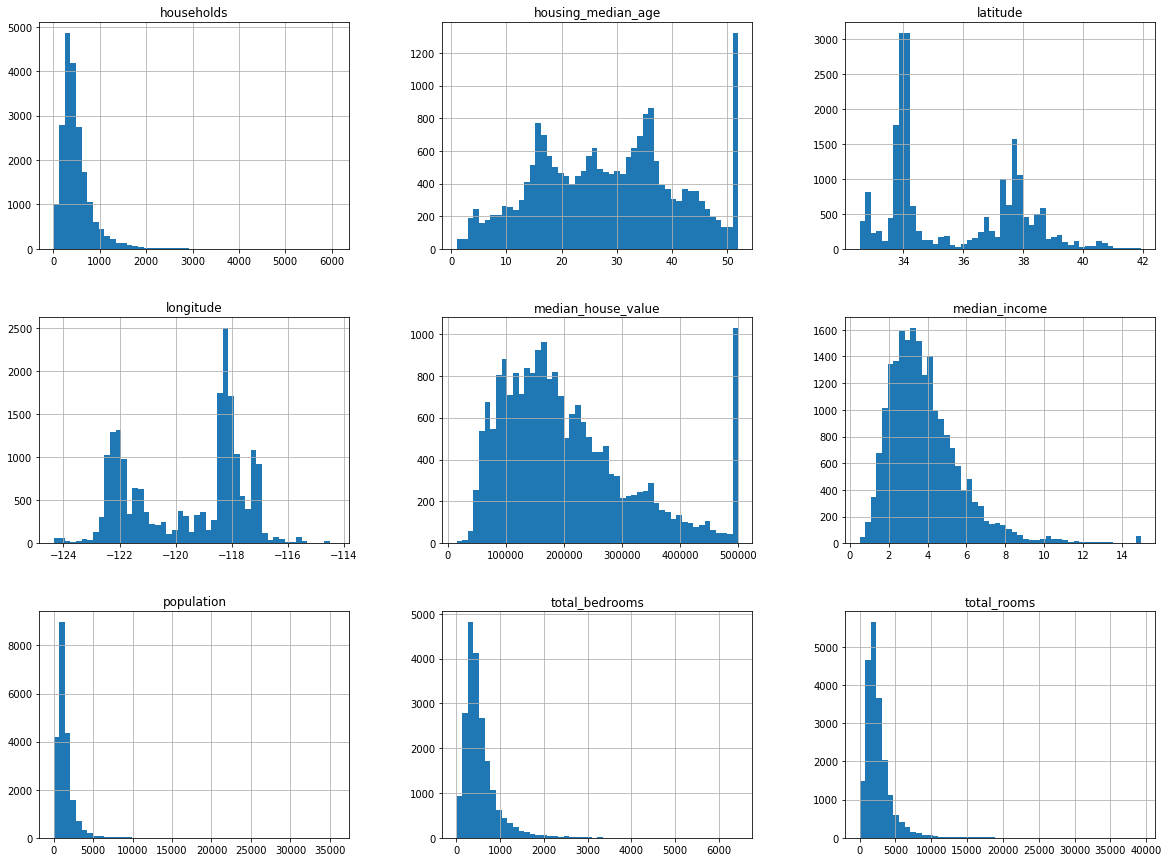

In [7]:
# Plot the data on histograms to understand distribution

%matplotlib inline
housing_df.hist(bins=50, figsize=(20,15))
plt.show()


In [8]:
#Split data into training and test set, use the 80%, 20% rule
train_data, test_data = train_test_split(housing_df, test_size=0.2,random_state=42)
print(train_data)

       longitude  latitude  ...  median_house_value  ocean_proximity
14196    -117.03     32.71  ...            103000.0       NEAR OCEAN
8267     -118.16     33.77  ...            382100.0       NEAR OCEAN
17445    -120.48     34.66  ...            172600.0       NEAR OCEAN
14265    -117.11     32.69  ...             93400.0       NEAR OCEAN
2271     -119.80     36.78  ...             96500.0           INLAND
...          ...       ...  ...                 ...              ...
11284    -117.96     33.78  ...            229200.0        <1H OCEAN
11964    -117.43     34.02  ...             97800.0           INLAND
5390     -118.38     34.03  ...            222100.0        <1H OCEAN
860      -121.96     37.58  ...            283500.0        <1H OCEAN
15795    -122.42     37.77  ...            325000.0         NEAR BAY

[16512 rows x 10 columns]


In [9]:

#Create strata to represent different median income groups for sampling to offset sampling bias
housing_df['income_cat'] = np.ceil(housing_df['median_income']/1.5)
housing_df["income_cat"] = np.where(housing_df["income_cat"] > 5, 5.0, housing_df['income_cat'])
print(housing_df)

#Plot distribution of income strata

#Stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
 strat_train_set = housing_df.loc[train_index]
 strat_test_set = housing_df.loc[test_index]

#Construct random sample dataframe incl. income categories
test_sample = housing_df[housing_df.index.isin(test_data.index)]
print(test_sample)

strat_smp = pd.DataFrame(get_prop(strat_test_set,'income_cat'))
overall_smp = pd.DataFrame(get_prop(housing_df, 'income_cat'))
random_smp = pd.DataFrame(get_prop(test_sample, 'income_cat'))


print(strat_smp)
print(overall_smp)
print(random_smp)


#Compare category proportions overall vs random vs stratified

compare_smp = overall_smp.merge(random_smp, left_index=True, right_index=True).merge(strat_smp, left_index=True, right_index=True)
compare_smp.reset_index(level=0, inplace=True)
compare_smp.columns = ['income_cat',
                       'Overall',
                       'Random',
                       'Stratified']

compare_smp['Rand. % error'] = ((compare_smp['Overall'] - compare_smp['Random'])/compare_smp['Random'])*100
compare_smp['Strat. % error'] = ((compare_smp['Overall'] - compare_smp['Stratified'])/compare_smp['Stratified'])*100

print(compare_smp.sort_values(by='income_cat'))


       longitude  latitude  ...  ocean_proximity  income_cat
0        -122.23     37.88  ...         NEAR BAY         5.0
1        -122.22     37.86  ...         NEAR BAY         5.0
2        -122.24     37.85  ...         NEAR BAY         5.0
3        -122.25     37.85  ...         NEAR BAY         4.0
4        -122.25     37.85  ...         NEAR BAY         3.0
...          ...       ...  ...              ...         ...
20635    -121.09     39.48  ...           INLAND         2.0
20636    -121.21     39.49  ...           INLAND         2.0
20637    -121.22     39.43  ...           INLAND         2.0
20638    -121.32     39.43  ...           INLAND         2.0
20639    -121.24     39.37  ...           INLAND         2.0

[20640 rows x 11 columns]
       longitude  latitude  ...  ocean_proximity  income_cat
0        -122.23     37.88  ...         NEAR BAY         5.0
3        -122.25     37.85  ...         NEAR BAY         4.0
6        -122.25     37.84  ...         NEAR BAY         3

In [0]:
# Cleaning up the stratified datasets

for set_ in (strat_train_set, strat_test_set):
 set_.drop("income_cat", axis=1, inplace=True)

       longitude  latitude  ...  income_cat    geolocation
0        -122.23     37.88  ...         5.0  -122.23,37.88
1        -122.22     37.86  ...         5.0  -122.22,37.86
2        -122.24     37.85  ...         5.0  -122.24,37.85
3        -122.25     37.85  ...         4.0  -122.25,37.85
4        -122.25     37.85  ...         3.0  -122.25,37.85
...          ...       ...  ...         ...            ...
20635    -121.09     39.48  ...         2.0  -121.09,39.48
20636    -121.21     39.49  ...         2.0  -121.21,39.49
20637    -121.22     39.43  ...         2.0  -121.22,39.43
20638    -121.32     39.43  ...         2.0  -121.32,39.43
20639    -121.24     39.37  ...         2.0  -121.24,39.37

[20640 rows x 12 columns]


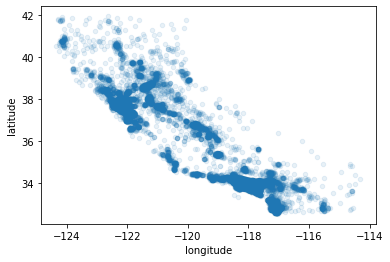

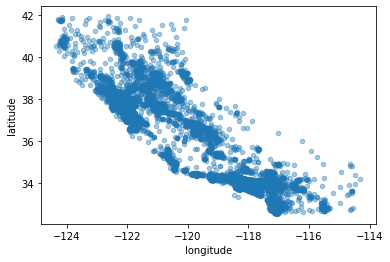

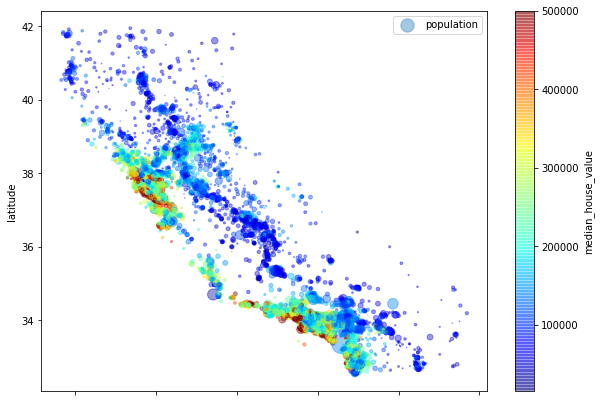

In [11]:
## Visualization preparation

##Saving dataframe to google drive for external visualizations
housing_df['geolocation'] = housing_df['longitude'].astype(str) + "," + housing_df['latitude'].astype(str)
print(housing_df)
housing_df.to_csv("housing.csv")
!cp housing.csv "drive/My Drive/ML-California housing"

## Matplot visuals

housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.40)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


In [12]:

## Plotly visuals

trace = go.Scatter(
    x = housing['longitude'],
    y = housing['latitude'],
    mode = 'markers',
    marker = dict(
        opacity = 0.1,
        size = housing['population']/200,
        color = housing['median_house_value'],  
        colorbar=dict(
            title='Median Income'
            ),
        colorscale='Plotly3',
    )
    
)
data = [trace]

layout = go.Layout(
					title = {
              'text': 'California Housing',
              'y':0.9,
              'x':0.5,
              'xanchor' : 'center'

          },

					paper_bgcolor = 'rgba(0,0,0,0)',
					plot_bgcolor = 'rgba(0,0,0,0)',
          width = 960,
          height = 672,
          
)

fig = go.Figure(data=data, layout=layout)
fig.show()

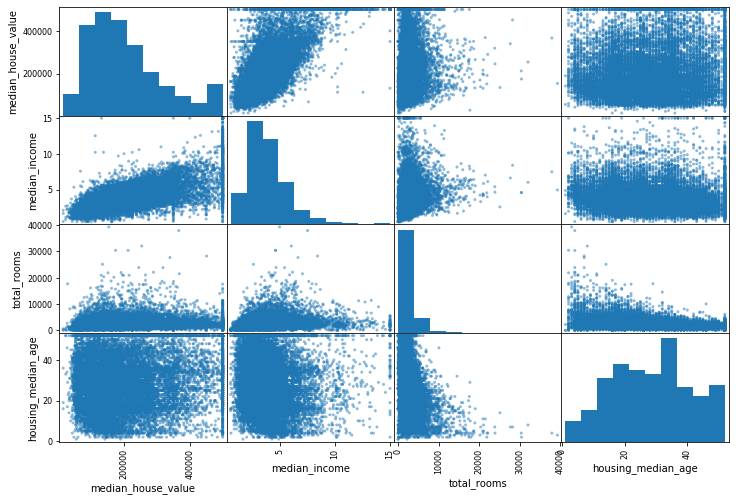

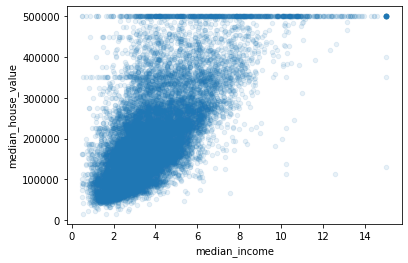

In [13]:

# Understanding correlations

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)

In [14]:
## Define more meaningful attributes
pd.set_option('display.max_columns', None)
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
#Looking at correlations of new attributes
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)



new_attributes = ['rooms_per_household', 
                    'bedrooms_per_room',
                    'population_per_household']
 
trace = go.Scatter(
    y = housing['median_house_value'],
    x = housing['rooms_per_household'],
    mode = 'markers',
    marker = dict(
        opacity = 0.1,
        size = housing['population']/400   
  )
)    
data = [trace]
layout = go.Layout(
  				title = {
              'text': 'Rooms per Household',
              'y':0.9,
              'x':0.5,
              'xanchor' : 'center'
            },
					paper_bgcolor = 'rgba(0,0,0,0)',
					plot_bgcolor = 'rgba(0,0,0,0)',
          width = 480,
          height = 360, 
                
  )
fig = go.Figure(data=data, layout=layout)
fig.show()


trace = go.Scatter(
    y = housing['median_house_value'],
    x = housing['bedrooms_per_room'],
    mode = 'markers',
    marker = dict(
        opacity = 0.1,
        size = housing['population']/400   
  )
)    
data = [trace]
layout = go.Layout(
  				title = {
              'text': 'Bedroom per room',
              'y':0.9,
              'x':0.5,
              'xanchor' : 'center'
            },
					paper_bgcolor = 'rgba(0,0,0,0)',
					plot_bgcolor = 'rgba(0,0,0,0)',
          width = 480,
          height = 360,       
  )
fig = go.Figure(data=data, layout=layout)
fig.show()


trace = go.Scatter(
    y = housing['median_house_value'],
    x = housing['population_per_household'],
    mode = 'markers',
    marker = dict(
        opacity = 0.1,
        size = housing['population']/400   
  )
)    
data = [trace]
layout = go.Layout(
  				title = {
              'text': 'Population per Household',
              'y':0.9,
              'x':0.5,
              'xanchor' : 'center'
            },
					paper_bgcolor = 'rgba(0,0,0,0)',
					plot_bgcolor = 'rgba(0,0,0,0)',
          width = 480,
          height = 360,       
  )
fig = go.Figure(data=data, layout=layout)
fig.show()



In [0]:
### Preparing the data for ML

# Create a copy of dataframe
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()



In [16]:
## Cleaning the data

#@ User scikit imputer method to replace n/a with median values (can replace with other aggregates)
#Drop non-numerical data for imputer method
housing_num = housing.drop("ocean_proximity", axis=1)

#Get median values of variables
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
imputer.statistics_

housing.median().values
X=imputer.transform(housing_num)
house_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
imputer.strategy
house_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
house_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [17]:


# Encode text attribute - OrdinalEncoder (converts text to numbers - useful for categorical variables)
# Not useful unless for ordered categories i.e scales - better to use one hot encoding (dummy variables)
house_ecat = ordinal_encoder.fit_transform(housing[['ocean_proximity']])
print(house_ecat)
#Scikit learn one hot encoding - create dummy for each ocean proximity category

house_cat_hote = cat_encoder.fit_transform(house_ecat)
print(house_cat_hote)


house_cat_hote.toarray()
cat_encoder.categories_


[[0.]
 [0.]
 [4.]
 ...
 [1.]
 [0.]
 [3.]]
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 1)	1.0
  (16489, 4)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 1)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 3)	1.0
  (16498, 1)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 4)	1.0
  (16503, 0)	1.0
  (16504, 1)	1.0
  (16505, 1)	1.0
  (16506, 0)	1.0
  (16507, 1)	1.0
  (16508, 1)	1.0
  (16509, 1)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0


[array([0., 1., 2., 3., 4.])]

In [18]:
## Customer transformers

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
house_extra_attribs = attr_adder.transform(housing.values)


house_extra_attribs = pd.DataFrame(
    house_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
house_extra_attribs.head()


#Feature Scaling - MinMax scaling (Normalization - convert values from 0 -1) of features vs. Standardization (substract mean and divide by standard deviation to convert to unit variance)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [19]:
#Building out pipeline to apply imute

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy="median")), #apply imute to all n/a in numerical columns
  ('attribs_adder', CombinedAttributesAdder()), #Apply combined attributes to dataset
  ('std_scaler', StandardScaler()), #Applyed standardization of features (0 mean and unit variance)
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(housing_num_tr)

[[-1.15604281  0.77194962  0.74333089 ... -0.31205452 -0.08649871
   0.15531753]
 [-1.17602483  0.6596948  -1.1653172  ...  0.21768338 -0.03353391
  -0.83628902]
 [ 1.18684903 -1.34218285  0.18664186 ... -0.46531516 -0.09240499
   0.4222004 ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.3469342  -0.03055414
  -0.52177644]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.02499488  0.06150916
  -0.30340741]
 [-1.43579109  0.99645926  1.85670895 ... -0.22852947 -0.09586294
   0.10180567]]


In [20]:

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prep = full_pipeline.fit_transform(housing)
housing_prep
housing_prep.shape

(16512, 16)

In [45]:
##Apply Linear Regression algorithm and Train and Test Model

lin_reg = LinearRegression()
lin_reg.fit(housing_prep, housing_labels)
lin_reg.score(housing_prep, housing_labels) #R2 value

0.6481624842804428

In [22]:
samples = housing.iloc[:5]

samples_labels = housing_labels.iloc[:5]
samples_prep  = full_pipeline.transform(samples)


#evaluate results
sample_predictions = lin_reg.predict(samples_prep)
print(samples_labels)
print('Predictions:', sample_predictions)



traceP = go.Scatter(
    y = sample_predictions,
    x = [1,2,3,4,5],
    mode = 'lines+markers',
    name = 'Sample Predictions'

)    

traceL = go.Scatter(
    y = samples_labels,
    x = [1,2,3,4,5],
    mode = 'lines+markers',
    name = 'Sample Labels'
    

)

data = [traceP, traceL]

layout = go.Layout(
  				title = {
              'text': 'Sample Predictions',
              'y':0.9,
              'x':0.5,
              'xanchor' : 'center'
            },
					paper_bgcolor = 'rgba(0,0,0,0)',
					plot_bgcolor = 'rgba(0,0,0,0)',
          width = 640,
          height = 480,       
  )
fig = go.Figure(data=data, layout=layout)
fig.show()




17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64
Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [40]:
#Evaluate mean squared error (average error (difference) predictions are from actuals)
lr_housing_preds = lin_reg.predict(housing_prep)
lreg_mse = mean_squared_error(housing_labels, lr_housing_preds)
lreg_rmse = np.sqrt(lreg_mse)
r

68628.19819848923

In [25]:
### Implementing different models

d_tree = DecisionTreeRegressor()
d_tree.fit(housing_prep, housing_labels)
#evaluate results
dt_housing_preds = d_tree.predict(housing_prep)
d_tmse = mean_squared_error(housing_labels,dt_housing_preds)
d_trmse = np.sqrt(d_tmse)
d_trmse

0.0

In [27]:
# Cross validation to evaluate Decision tree - K fold cross validation: Split data into 10 folds (train and evalutes model each fold)

d_scores = cross_val_score(d_tree, housing_prep, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

d_rmse_scores = np.sqrt(-d_scores)

def display_scores(d_scores):
  print("Scores:", d_scores)
  print("Mean:", d_scores.mean())
  print("Standard deviation:", d_scores.std())

display_scores(d_rmse_scores)

# Cross validation to evaluate Linear Regression Model

lin_scores = cross_val_score(lin_reg, housing_prep, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)



Scores: [69804.02330127 66626.42830887 69188.44407568 68910.3105131
 71621.30165531 75489.90655821 71036.73588181 71799.25270475
 74937.62668351 69946.45804655]
Mean: 70936.04877290633
Standard deviation: 2568.392778203322
Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


In [30]:
# Evaluate Random Forest Regressor
rdm_foreg = RandomForestRegressor()
rdm_foreg.fit(housing_prep,housing_labels)
rdm_housing_preds = rdm_foreg.predict(housing_prep)
rdm_foreg_mse = mean_squared_error(housing_labels, rdm_housing_preds)
rdm_foreg_rmse = np.sqrt(rdm_foreg_mse)
rdm_foreg_rmse

forest_scores = cross_val_score(rdm_foreg, housing_prep, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

NameError: ignored

In [32]:
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)



Scores: [49597.48496927 47709.52689424 49992.78835897 52105.15989484
 49590.42335128 53625.11230131 49262.11845725 47992.53652754
 53016.97113366 50262.71133601]
Mean: 50315.483322436754
Standard deviation: 1894.714790714866


In [51]:
#store models

filename_lr = 'lm_reg.pkl'
joblib.dump(lin_reg, filename_lr)
 
filename_dt = 'd_tree.pkl'
joblib.dump(d_tree, filename_dt)
 
filename_rf = 'rdm_foreg.pkl'
joblib.dump(rdm_foreg, filename_rf)
 
# Test load of stored models


filename = [filename_lr, filename_dt, filename_rf]

for i in filename:
  loaded_model = joblib.load(i)
  result = loaded_model.score(housing_prep, housing_labels)
  print(result)
  print("Test score: {0:.2f} %".format(100 * result))



0.6481624842804428
Test score: 64.82 %
1.0
Test score: 100.00 %
0.9738098745601667
Test score: 97.38 %


In [61]:
#Fine tune hyperparameters
#Grid search gets and evaluates all possible combinations of hyperparameters you define. (useful for small number of hyper parameters)

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, #Define number of trees, #max number of features when splitting node
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]

rdm_foreg = RandomForestRegressor()

grid_search = GridSearchCV(rdm_foreg, param_grid, cv=5,

scoring='neg_mean_squared_error',

return_train_score=True)

grid_search.fit(housing_prep, housing_labels)


{'max_features': 8, 'n_estimators': 30}

In [67]:
grid_search.best_params_
grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)



63679.84060366251 {'max_features': 2, 'n_estimators': 3}
55663.59956992742 {'max_features': 2, 'n_estimators': 10}
52717.11669118171 {'max_features': 2, 'n_estimators': 30}
60221.77493527242 {'max_features': 4, 'n_estimators': 3}
52981.46462291086 {'max_features': 4, 'n_estimators': 10}
50972.63954782333 {'max_features': 4, 'n_estimators': 30}
59068.98539616661 {'max_features': 6, 'n_estimators': 3}
52028.15990921304 {'max_features': 6, 'n_estimators': 10}
50366.23137782813 {'max_features': 6, 'n_estimators': 30}
59002.91861604005 {'max_features': 8, 'n_estimators': 3}
52087.741296595144 {'max_features': 8, 'n_estimators': 10}
50123.63846924519 {'max_features': 8, 'n_estimators': 30}
62462.3170276665 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54519.33426098238 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59969.09540966636 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52402.53345027589 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [69]:
#Randomized Seach - Useful for large number of hyper parameters

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high= 8),
}

rdm_foreg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(rdm_foreg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring ="neg_mean_squared_error", random_state=42)
rnd_search.fit(housing_prep, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [93]:
## Random Seach Cross Validation results

cves_results(rnd_search)


49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [100]:
#Examinating Model & Errors to understand what features are important.

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances,attributes), reverse=True)

[(0.39228136989236084, 'median_income'),
 (0.14235909024845234, 'INLAND'),
 (0.1065916444712736, 'pop_per_hhold'),
 (0.07148947264541357, 'longitude'),
 (0.06442596828791497, 'latitude'),
 (0.051598035642661605, 'rooms_per_hhold'),
 (0.051372552203895645, 'bedrooms_per_room'),
 (0.04297273988654638, 'housing_median_age'),
 (0.016514084079952078, 'total_rooms'),
 (0.015040859803787438, 'total_bedrooms'),
 (0.01463751080002217, 'population'),
 (0.014055252499370471, 'households'),
 (0.010542936319813673, '<1H OCEAN'),
 (0.003973202472965103, 'NEAR OCEAN'),
 (0.001989746259271145, 'NEAR BAY'),
 (0.00015553448629891632, 'ISLAND')]

In [104]:
#Final model

test_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prep = full_pipeline.transform(X_test)
test_predictions = test_model.predict(X_test_prep)
test_mse = mean_squared_error(y_test, final_predictions)
test_rmse = np.sqrt(final_mse)


confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)))

array([45345.83981122, 49223.48913422])